In [1]:
# Load packages:
import pandas as pd 
import numpy as np 

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('pdf', 'svg')

# Data Summary

In this project, I am using tennis data from the 2019 ATP matches (obtained from https://github.com/JeffSackmann/tennis_atp). I cleaned it as part of the Exploratory Data Analysis Course, and save a copy as 'atp_matches_2019_clean.csv' (steps detailed in *Cleaning Summary* below). In this dataframe, each row shows individual match stats for a player. 

Variable key:  
* match_id = unique code for the match (so shared by two rows - one for winner, one for loser)  
* outcome = whether the player won (w) or lost (l)  
* ace_per = percentage of service points that were aces  
* df_per = percentage of service points that were double faults  
* bpFaced_per = percentage of service points where the player faced a break point  
* 1stIn_per = percentage of service points where the first serve was in  
* 1stWon_per = percentage of 1st serves where the point was won  
* 2ndWon_per = percentage of 2nd serves where the point was won  
* pt_per = percentage of total match points that the player won

In [2]:
tennis_df = pd.read_csv('atp_matches_2019_clean.csv')
tennis_df.head(10)

,match_id,outcome,name,age,ace_per,df_per,bpFaced_per,1stIn_per,1stWon_per,2ndWon_per,pt_per
0,0,w,Kei Nishikori,29.004791,1.955930,2.123021,7.792208,57.142857,70.454545,56.666667,53.107345
1,1,w,Daniil Medvedev,22.885695,4.510174,1.301106,1.923077,63.461538,84.848485,77.777778,58.914729
2,2,w,Kei Nishikori,29.004791,2.062797,2.247840,4.255319,70.212766,78.787879,75.000000,64.516129
3,3,w,Jo-Wilfried Tsonga,33.705681,4.337238,1.759191,7.352941,63.235294,79.069767,65.217391,55.704698
4,4,w,Daniil Medvedev,22.885695,3.527772,1.724531,7.619048,64.761905,70.588235,73.529412,51.256281
5,5,w,Jeremy Chardy,31.882272,3.404345,3.424165,8.510638,61.702128,75.862069,64.285714,51.086957
6,6,w,Kei Nishikori,29.004791,3.030941,1.936540,1.694915,79.661017,78.723404,90.000000,54.676259
7,7,w,Jo-Wilfried Tsonga,33.705681,4.285008,2.390860,10.937500,57.812500,81.081081,45.833333,54.362416
8,8,w,Alex De Minaur,19.868583,1.284753,1.358932,0.000000,77.551020,76.315789,80.000000,57.142857
9,9,w,Daniil Medvedev,22.885695,5.447646,2.053701,1.851852,62.962963,79.411765,72.222222,57.894737


In [3]:
tennis_df.dtypes

match_id         int64
outcome         object
name            object
age            float64
ace_per        float64
df_per         float64
bpFaced_per    float64
1stIn_per      float64
1stWon_per     float64
2ndWon_per     float64
pt_per         float64
dtype: object

In [4]:
tennis_df.shape

(5296, 11)

## Cleaning Summary

In a prior notebook (for the Exploratory Data Analysis Course), I cleaned the original data by:    
* checking for and removing rows with missing values  
* transforming heavily skewed variables with box-cox transform  
* removing outliers using 2 * IQR  

## Format for Analyses
For the current analyses, I'm going to be focusing on individual players and not matches. Because I'll be averaging across each player's matches, I'm only considering those who have played at least 5 times in the year:

In [5]:
# players who played at least 5 matches in 2019:
match_counts = tennis_df.groupby('name').count()
names = match_counts.index[match_counts.match_id >=5].tolist()

# filter df:
tennis_df = tennis_df[tennis_df['name'].isin(names)]

In [6]:
print('This dataset contains information for ' + str(len(tennis_df.name.unique())) + ' players over ' + str(len(tennis_df.match_id.unique())) + ' matches')

This dataset contains information for 164 players over 2662 matches


Now I'm going to group by players and summarise each of my features to get the average match stats per player in 2019:

In [7]:
# mean of continuous variables:
player_df = tennis_df.groupby('name').mean().drop(['match_id','pt_per'], axis=1)

# add the % of their matches that they won:
wins = (tennis_df.groupby('name')["outcome"]
        .value_counts(normalize=True)
        .to_frame()
        .rename(columns={"outcome":"value"})
        .reset_index()
        .pivot(index="name",columns="outcome",values="value")
        .reset_index()
        .fillna(0)
       )

In [8]:
player_df = player_df.merge(wins.drop("l", axis=1), on="name")
player_df.head()

,name,age,ace_per,df_per,bpFaced_per,1stIn_per,1stWon_per,2ndWon_per,w
0,Adrian Mannarino,30.992734,2.628861,1.505509,7.748114,59.768851,71.822690,57.523607,0.519231
1,Albert Ramos,31.357328,1.888347,1.326321,7.874975,63.600401,69.740544,58.461562,0.566038
2,Alejandro Davidovich Fokina,19.958111,1.434778,1.910521,11.196125,71.536233,61.161494,53.662835,0.300000
3,Alex Bolt,26.127310,2.742567,1.624983,9.126861,55.921580,71.269908,52.730918,0.428571
4,Alex De Minaur,20.352156,2.092616,1.630736,6.047510,61.683252,75.398451,59.616491,0.660714


The ***target (Y)*** is w (the percentage of games won by a player in 2019), and ***features (X)*** are the remaining continuous variables (age and mean performance stats).

Distribution of my variables:

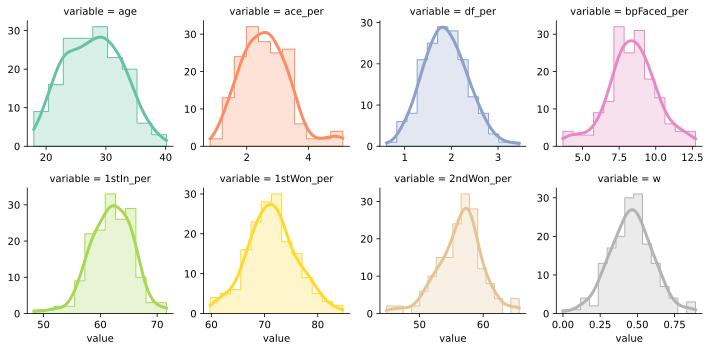

In [9]:
melted_df = player_df.select_dtypes("float").melt()

grid = sns.FacetGrid(melted_df, col='variable', col_wrap=4,
                     hue='variable', palette='Set2',
                     height=2.5, aspect=1,
                     sharex = False, sharey = False) 

grid.map(sns.histplot, "value", alpha=.25,
         kde=True, line_kws={"lw":3}, element="step")

Correlations between my variables:

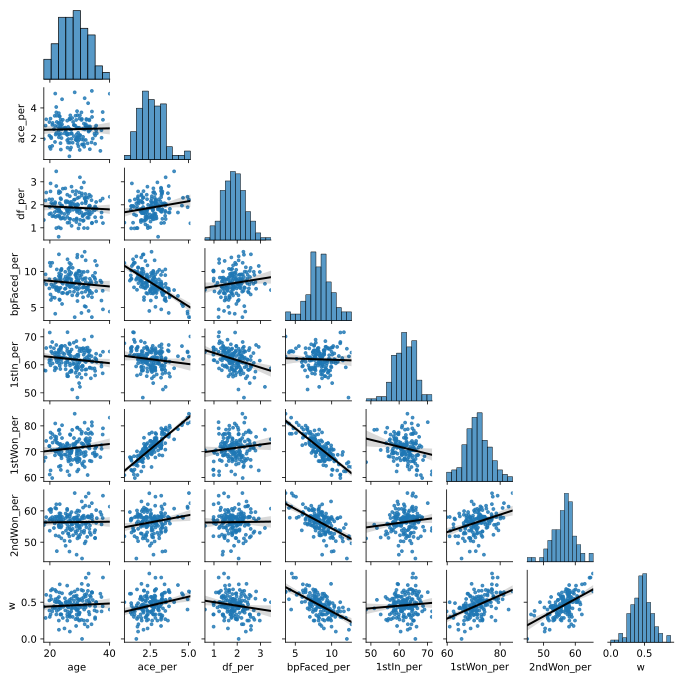

In [10]:
sns.pairplot(player_df.select_dtypes("float"), 
             kind="reg", height=1.2, corner=True,
             plot_kws={'scatter_kws':{'s':8},
                       'line_kws':{'color':'black',
                                   'lw':2}})
plt.show()

# Analysis Objectives

The goals of this analysis is to train linear regression models, predicting each player's percentage of games won ('w') with various features, including age and indices of match performance. Ideally, I want to build a model that best predicts performance success over the year.  

First, I will divide my data into a training (75%) and test (25%) set. I will use the same training and test sets to compare performance of the following models:  
* 1) Linear regression, with all match statistics as features  
* 2) Linear regression, same as above but also including age and interactions of match statistics with age as predictors   
* 3) A Lasso regression model, including all features from model (2)  
* 4) A Lasso regression model, including all features and all of their quadratic terms.  

Cross-validation using the training set data will be used to select the best alpha for my lasso regression models.  

# Regression Models

## Model 1: Simple Linear Regression

In [11]:
# X and y data:
X = player_df.select_dtypes("float").drop(['w','age'], axis=1)
y = player_df["w"]
X.head()

,ace_per,df_per,bpFaced_per,1stIn_per,1stWon_per,2ndWon_per
0,2.628861,1.505509,7.748114,59.768851,71.822690,57.523607
1,1.888347,1.326321,7.874975,63.600401,69.740544,58.461562
2,1.434778,1.910521,11.196125,71.536233,61.161494,53.662835
3,2.742567,1.624983,9.126861,55.921580,71.269908,52.730918
4,2.092616,1.630736,6.047510,61.683252,75.398451,59.616491


Set up my pipeline for the LR model (standardizing my features and fitting the regression model) and predict on a test set:

In [12]:
# divide data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=100)

In [13]:
print(X_train.shape)
print(X_test.shape)

(123, 6)
(41, 6)


In [14]:
# fit the model and predict new values:
s = StandardScaler()
lr = LinearRegression()

model1 = Pipeline([("scaler", s),
                   ("linear_regression", lr)])
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

In [15]:
# calculate the r-squared score scross the different train-test splits:
r2_score(y_test, y_pred)

0.6249453245362065

Show predicted vs. actual values:

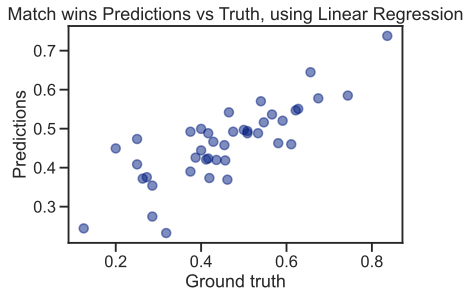

In [16]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Match wins Predictions vs Truth, using Linear Regression');

Model coefficients:

In [17]:
pd.DataFrame(list(zip(model1.named_steps["linear_regression"].coef_, X.columns)),
             columns=['Coefficient','Feature'])

,Coefficient,Feature
0,-0.068733,ace_per
1,-0.012956,df_per
2,-0.016698,bpFaced_per
3,0.014965,1stIn_per
4,0.101457,1stWon_per
5,0.043755,2ndWon_per


This basic linear regression model does a reasonable job at predicting overall match performance (r-squared = 0.62), showing that the abilty to win points from a 1st serve is a particularly important indicator of match success.

## Model 2: Age Interaction Linear Regression

Create interaction terms (age * feature):

In [18]:
# re-define X to include age
X = player_df.select_dtypes("float").drop(['w'], axis=1)

pf = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_age = pf.fit_transform(X)
X_age = pd.DataFrame(X_age, columns=pf.get_feature_names(X.columns))

# keep only interaction terms with 'age'
age_interactions = [col for col in X_age.columns if 'age ' in col]
X_age = X_age[X.columns.tolist() + age_interactions]
X_age.head()

,age,ace_per,df_per,bpFaced_per,1stIn_per,1stWon_per,2ndWon_per,age ace_per,age df_per,age bpFaced_per,age 1stIn_per,age 1stWon_per,age 2ndWon_per
0,30.992734,2.628861,1.505509,7.748114,59.768851,71.822690,57.523607,81.475590,46.659841,240.135224,1852.400116,2225.981537,1782.813873
1,31.357328,1.888347,1.326321,7.874975,63.600401,69.740544,58.461562,59.213525,41.589898,246.938174,1994.338645,2186.877144,1833.198404
2,19.958111,1.434778,1.910521,11.196125,71.536233,61.161494,53.662835,28.635467,38.130383,223.453511,1427.728073,1220.667882,1071.008816
3,26.127310,2.742567,1.624983,9.126861,55.921580,71.269908,52.730918,71.655909,42.456439,238.460335,1461.080465,1862.090977,1377.717035
4,20.352156,2.092616,1.630736,6.047510,61.683252,75.398451,59.616491,42.589248,33.188997,123.079876,1255.387175,1534.521032,1213.324131


Now run the same linear regression pipeline as above:

In [19]:
# divide data into train and test sets (fixing random state, so same splits as before):
X_train, X_test, y_train, y_test = train_test_split(X_age, y, 
                                                    test_size=0.25, random_state=100)

In [20]:
# fit the model and predict new values:
model2 = Pipeline([("scaler", s),
                   ("linear_regression", lr)])
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

In [21]:
# calculate the r-squared score across the different train-test splits:
r2_score(y_test, y_pred)

0.6558268527672184

Incorporating age and interactions with age provides us with a better (albeit slightly) ability to predict match success (r-squared = 0.66).

## Model 3: Age Interaction Lasso Regression

Now, instead of standard linear regression as in models 1 and 2, I'm going to run Lasso regression to reduce the influence of features that aren't useful for prediction.  
First, I'm using cross-validation to select the best value of alpha for regularization. Note that my features are standardized with StandardScaler() before running the cross validation.

In [22]:
# fit the model and predict new values,
# first tuning alphs with CV:
s = StandardScaler()
lassoCV = LassoCV(max_iter=5e4)

model3 = Pipeline([("scaler", s),
                   ("lasso_regression", lassoCV)])
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)

In [23]:
lassoCV_r2 = r2_score(y_test, y_pred)
print(model3.named_steps["lasso_regression"].alpha_, lassoCV_r2)

0.0009025640191179066 0.6152423754532159


In [24]:
pd.DataFrame(list(zip(model3.named_steps["lasso_regression"].coef_, X_age.columns)),
             columns=['Coefficient','Feature'])

,Coefficient,Feature
0,0.000000,age
1,-0.017649,ace_per
2,-0.012524,df_per
3,-0.013590,bpFaced_per
4,0.013599,1stIn_per
5,0.090566,1stWon_per
6,0.033203,2ndWon_per
7,-0.052524,age ace_per
8,-0.000000,age df_per
9,-0.008288,age bpFaced_per


The lasso regression is able to zero-out some of the features, highlighting those that make a small or no contribution to the model. Interestingly, it looks as if age positively interacts with 2nd serve success (final coefficient), suggesting that winning off second serves is most important for older players. The opposite is true for aces, suggesting that younger players benefit the most from aces in terms of their match success.  

However, the model's ability to predict match success is slightly worse than the equivalent linear regression (r-squared = 0.62 vs. 0.66), perhaps because the number of feature we have is relatively small.

## Model 4: Lasso Regression with Quadratic terms

This final model uses all 7 features (age and match stats), also including all of their quadratic terms (degree = 2).

In [25]:
# re-define pf
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)
X_pf = pd.DataFrame(X_pf, columns=pf.get_feature_names(X.columns))
X_pf.head()

,age,ace_per,df_per,bpFaced_per,1stIn_per,1stWon_per,2ndWon_per,age^2,age ace_per,age df_per,...,bpFaced_per^2,bpFaced_per 1stIn_per,bpFaced_per 1stWon_per,bpFaced_per 2ndWon_per,1stIn_per^2,1stIn_per 1stWon_per,1stIn_per 2ndWon_per,1stWon_per^2,1stWon_per 2ndWon_per,2ndWon_per^2
0,30.992734,2.628861,1.505509,7.748114,59.768851,71.822690,57.523607,960.549571,81.475590,46.659841,...,60.033264,463.095847,556.490359,445.699443,3572.315572,4292.759667,3438.119931,5158.498791,4131.500220,3308.965410
1,31.357328,1.888347,1.326321,7.874975,63.600401,69.740544,58.461562,983.282036,59.213525,41.589898,...,62.015230,500.851562,549.205039,460.383339,4045.010979,4435.526573,3718.178800,4863.743531,4077.141188,3417.754280
2,19.958111,1.434778,1.910521,11.196125,71.536233,61.161494,53.662835,398.326190,28.635467,38.130383,...,125.353223,800.928634,684.771755,600.815830,5117.432655,4375.262905,3838.837094,3740.728365,3282.099183,2879.699887
3,26.127310,2.742567,1.624983,9.126861,55.921580,71.269908,52.730918,682.636331,71.655909,42.456439,...,83.299597,510.388506,650.470562,481.267771,3127.223133,3985.525861,2948.796240,5079.399747,3758.127634,2780.549675
4,20.352156,2.092616,1.630736,6.047510,61.683252,75.398451,59.616491,414.210256,42.589248,33.188997,...,36.572382,373.030111,455.972916,360.531352,3804.823603,4650.821640,3677.339058,5684.926343,4494.991057,3554.126014


In [26]:
# divide data into train and test sets (fixing random state, so same splits as before):
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, 
                                                    test_size=0.25, random_state=100)

In [27]:
# fit the model and predict new values,
# first tuning alphs with CV:
s = StandardScaler()
lassoCV = LassoCV(max_iter=5e4)

model4 = Pipeline([("scaler", s),
                   ("lasso_regression", lassoCV)])
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)

In [28]:
lassoCV_r2 = r2_score(y_test, y_pred)
print(model4.named_steps["lasso_regression"].alpha_, lassoCV_r2)

0.008578981501550441 0.5745857967142914


Let's compare that to a standard linear regression without regulatization, but with identical features:

In [29]:
# fit the model and predict new values:
model4_lr = Pipeline([("scaler", s),
                      ("linear_regression", lr)])
model4_lr.fit(X_train, y_train)
y_pred = model4_lr.predict(X_test)
r2_score(y_test, y_pred)

0.4117893625217215

So in this situation, where we have many features, lasso regression helps the predictive performance of the model (r-squared = 0.57 vs. 0.41). But performance is still lower than the simpler linear model (2) just considering age interactions.

# Key Findings

The key finding from the above linear regression comparisons are that: 

* Model 2 - linear regression with 7 features (age and match stats) + 6 interactions between age and match stats — is the best model for predicting overall match success.  
* In situations with few features, lasso regression does not help the predictive performance of our model.  
* In situations with more features, lasso regression can improve the model's predictive performance, but it still does not improve upon Model 2.  
* Overall, the models show that winning points from 1st and 2nd serves are important for match success, but that considering interactions with age and between match stats (e.g. winning more 1st serves *and* 2nd serves) might help explain performamce.  

# Problems and Future Directions

The above models ran into a few problems — for example, the limited number of features meant that r-squared never went above 0.65, and the features largely show a linear relationship with match success. More features would be helpful to fully characertize a predictive model of match success. For example, sleep, diet, and other individual (non-match) factors would be important to helpful. 

Future directions would be to consider the data in a different format — rather than summarising by individual players, I could consider each match and the relative difference in performance between players. For example, while a player's age must not be predictive of match success overall, it might be if there is a large difference in age between opponents. I could also predict whether a player would win or lose individual matches with classification, rather than considering their average performance across the year.